# Neal's Funnel Target Practice

In [2]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [3]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [4]:
d = 100
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [5]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [-0.7000916488759461, 2.240072211204444, -1.9972072526060893, 2.4069536537671516, 1.3217580250448449, -0.46525017055466317, 0.46526223322754534, 0.48529453229761566, 0.4223647063730074, -0.6165926885926534, -0.4049009180298786, 0.7319941747470347, 0.0015676277201058242, -0.28912083082405243, 3.9097843007513484, -1.0817079874110134, 0.4823694322814166, -1.2137092817191666, 0.16083763093668008, -0.3299361037576759, 2.301756755607073, -0.7479639385553154, -2.2073026357011547, 2.155371265107117, -0.7715672908373141, -0.4252651544460204, 2.351256075894668, 2.245309970869048, -2.2558683598350466, -1.6514671283965852, -1.5246456987592987, -1.9422922101452205, 0.6518996875677049, 0.9898568306698484, 0.8818150636072517, -0.3726476764393216, -0.6622763100479866, 0.63900

## MCHMC

In [6]:
alpha_eps = 0.25
alpha_L = 0.11

truth_alpha_eps = 0.25
truth_alpha_L = 0.11;

In [21]:
target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)

true_target = NealFunnelTarget(true_model; d=d, compute_MAP=false)

spl = MCHMC(alpha_eps*sqrt(d), alpha_L*sqrt(d); init_eps=0.3, varE_wanted=1.0, sigma=ones(d))

true_spl = MCHMC(truth_alpha_eps*sqrt(d), truth_alpha_L*sqrt(d); init_eps=0.3, varE_wanted=1.0, sigma=ones(d))

MicroCanonicalHMC.Sampler(Settings(MersenneTwister(0), 1.0, 0, 1000, 100, "LF", 0.3, nothing, nothing), Hyperparameters(2.5, 1.1, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [22]:
samples_mchmc = Sample(spl, target, 50_000;
                       burn_in=20_000, dialog=true);

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Starting burn in
[ Info: Burn in finished


In [23]:
truth_mchmc = Sample(true_spl, true_target, 50_000;
               burn_in=20_000, dialog=true);

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Starting burn in
[ Info: Burn in finished


In [24]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];

In [25]:
true_theta_mchmc = [sample[1] for sample in truth_mchmc]
true_x10_mchmc = [sample[10+1] * exp(sample[1]/2) for sample in truth_mchmc];

In [26]:
VarE = std(E)^2/d

160.71847771317312

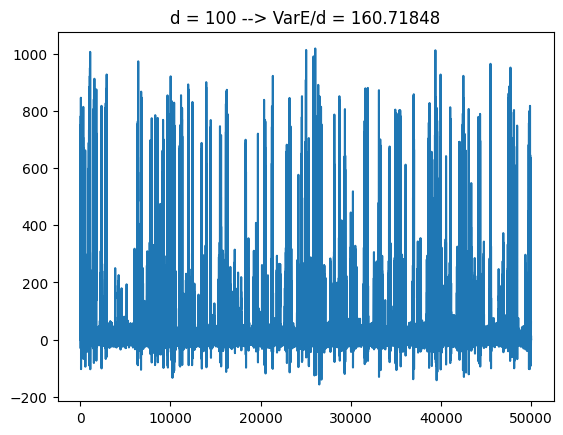

PyObject Text(0.5, 1.0, 'd = 100 --> VarE/d = 160.71848')

In [27]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

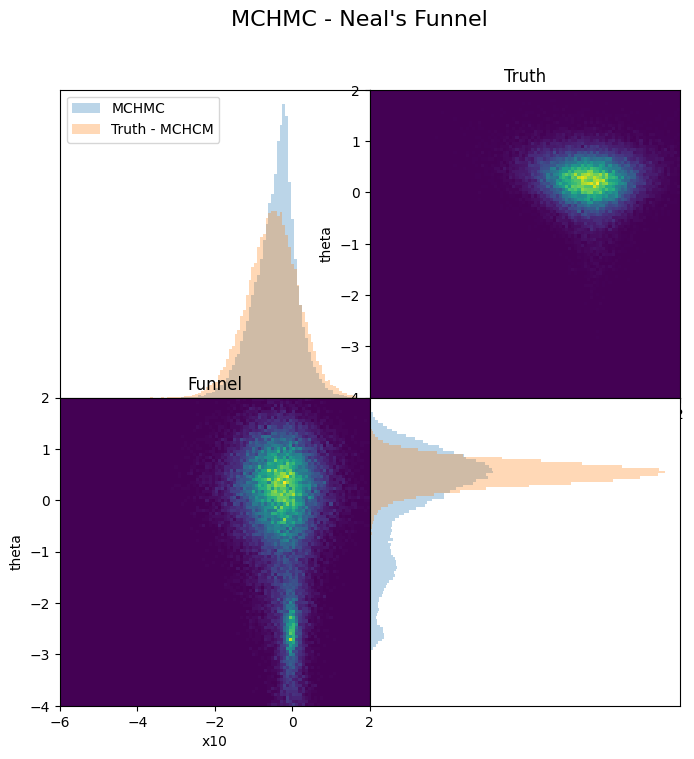

In [28]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(true_x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - MCHCM")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_mchmc, true_theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

## NUTS

In [15]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:44


Chains MCMC chain (50000×112×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 472.21 seconds
Compute duration  = 472.21 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], z[24], z[25], z[26], z[27], z[28], z[29], z[30], z[31], z[32], z[33], z[34], z[35], z[36], z[37], z[38], z[39], z[40], z[41], z[42], z[43], z[44], z[45], z[46], z[47], z[48], z[49], z[50], z[51], z[52], z[53], z[54], z[55], z[56], z[57], z[58], z[59], z[60], z[61], z[62], z[63], z[64], z[65], z[66], z[67], z[68], z[69], z[70], z[71], z[72], z[73], z[74], z[75], z[76], z[77], z[78], z[79], z[80], z[81], z[82], z[83], z[84], z[85], z[86], z[87], z[88], z[89], z[90], z[91], z[92], z[93], z[94], z[95], z[96], z[97], z[98], z[99]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy,

In [16]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:06:02


Chains MCMC chain (50000×112×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 366.82 seconds
Compute duration  = 366.82 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20], z[21], z[22], z[23], z[24], z[25], z[26], z[27], z[28], z[29], z[30], z[31], z[32], z[33], z[34], z[35], z[36], z[37], z[38], z[39], z[40], z[41], z[42], z[43], z[44], z[45], z[46], z[47], z[48], z[49], z[50], z[51], z[52], z[53], z[54], z[55], z[56], z[57], z[58], z[59], z[60], z[61], z[62], z[63], z[64], z[65], z[66], z[67], z[68], z[69], z[70], z[71], z[72], z[73], z[74], z[75], z[76], z[77], z[78], z[79], z[80], z[81], z[82], z[83], z[84], z[85], z[86], z[87], z[88], z[89], z[90], z[91], z[92], z[93], z[94], z[95], z[96], z[97], z[98], z[99]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy,

In [17]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [18]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


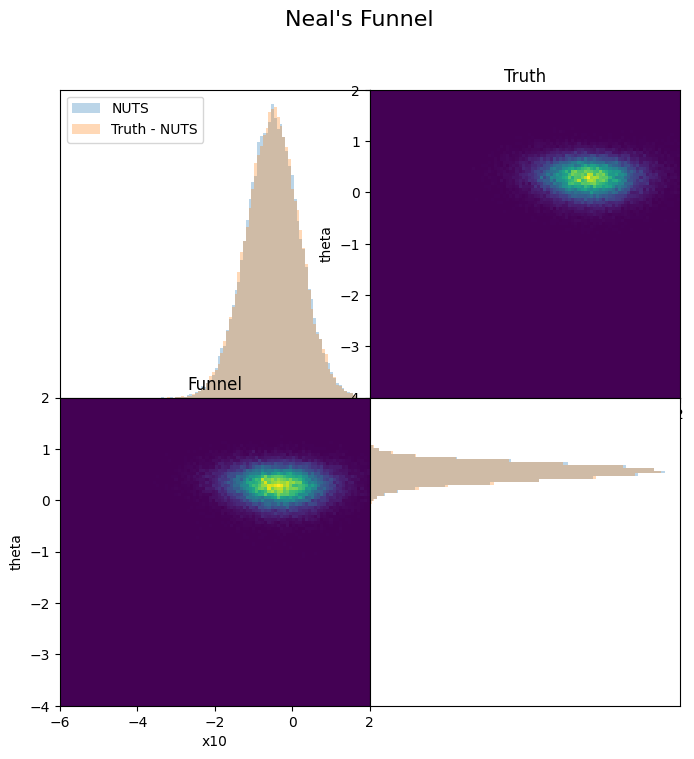

In [29]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

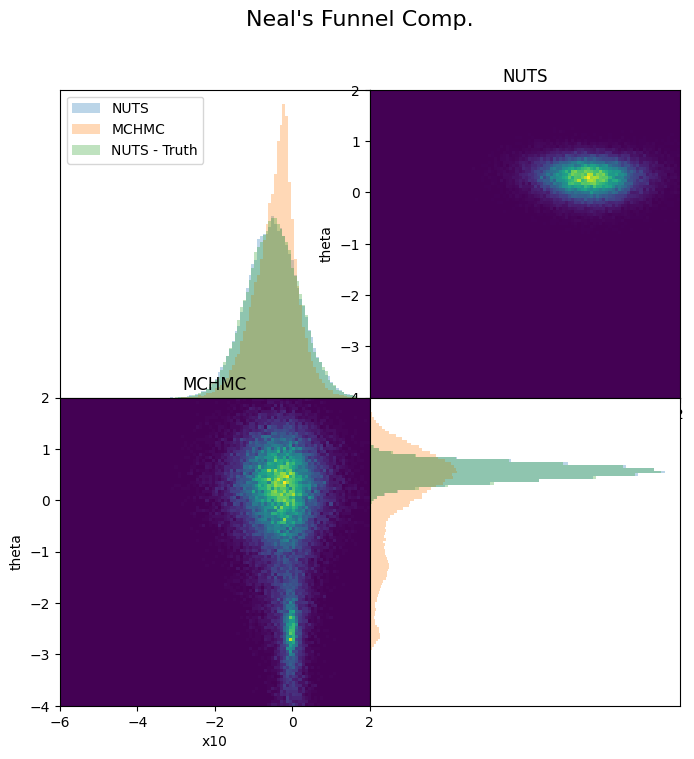

In [30]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100,  orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;